# Forward Modeling of an Emission Spectrum

In [1]:
from exojax.rt import rtransfer as rt

In [2]:
#ATMOSPHERE                                                                     
NP=100
T0=1295.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.1

A T-P profile we assume is ...  

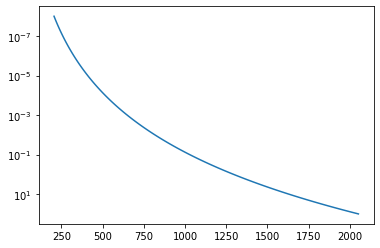

In [3]:
import matplotlib.pyplot as plt
plt.plot(Tarr,Parr)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.show()

We set a wavenumber grid using wavenumber_grid.

In [4]:
from exojax.utils.grids import wavenumber_grid
nus,wav,res=wavenumber_grid(22920,23000,1000,unit="AA")

xsmode assumes ESLOG in wavenumber space: mode=lpf


/home/kawahara/exojax/src/exojax/utils/grids.py:124: UserWarning: Resolution may be too small. R=286712.70993002696
  warnings.warn('Resolution may be too small. R=' + str(resolution),


Loading a molecular database of CO and CIA (H2-H2)... 

In [5]:
from exojax.database import api , contdb
mdbCO=api.MdbExomol('.database/CO/12C-16O/Li2015',nus,crit=1.e-46)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading .database/CO/12C-16O/Li2015/12C-16O__Li2015.trans.bz2
.broad is used.
Broadening code level= a0
H2-H2


In [6]:
from exojax.database import molinfo 
molmassCO=molinfo.molmass("CO")

Computing the relative partition function, 

In [7]:
from jax import vmap
qt=vmap(mdbCO.qr_interp)(Tarr)

Pressure and Natural broadenings 

In [8]:
from jax import jit
from exojax.database.exomol  import gamma_exomol
from exojax.database.hitran import gamma_natural

gammaLMP = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr,Tarr,mdbCO.n_Texp,mdbCO.alpha_ref)
gammaLMN=gamma_natural(mdbCO.A)
gammaLM=gammaLMP+gammaLMN[None,:]

Doppler broadening

In [9]:
from exojax.database.hitran import doppler_sigma
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
        (mdbCO.nu_lines,Tarr,molmassCO)

And line strength

In [10]:
from exojax.database.hitran import SijT
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)

nu matrix

In [ ]:
from exojax.opacity.lpf.make_numatrix import make_numatrix0
numatrix=make_numatrix0(nus,mdbCO.nu_lines)

Or you can use initspec.init_lpf instead.

In [12]:
#Or you can use initspec.init_lpf instead.
from exojax.opacity import initspec
numatrix=initspec.init_lpf(mdbCO.nu_lines,nus)

Providing numatrix, thermal broadening, gamma, and line strength, we can compute cross section. 

In [ ]:
from exojax.opacity.lpf.lpf import xsmatrix
xsm=xsmatrix(numatrix,sigmaDM,gammaLM,SijM)

xsmatrix has the shape of (# of layers, # of nu grid)

In [14]:
import numpy as np
np.shape(xsm)

(100, 1000)

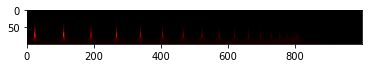

In [15]:
import numpy as np
plt.imshow(xsm,cmap="afmhot")
plt.show()

computing delta tau for CO

In [16]:
from exojax.rt.rtransfer import dtauM
Rp=0.88
Mp=33.2
g=2478.57730044555*Mp/Rp**2
#g=1.e5 #gravity cm/s2
MMR=0.0059 #mass mixing ratio
dtaum=dtauM(dParr,xsm,MMR*np.ones_like(Tarr),molmassCO,g)

computing delta tau for CIA

In [17]:
from exojax.rt.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

The total delta tau is a summation of them

In [18]:
dtau=dtaum+dtaucH2H2

you can plot a contribution function using exojax.plot.atmplot 

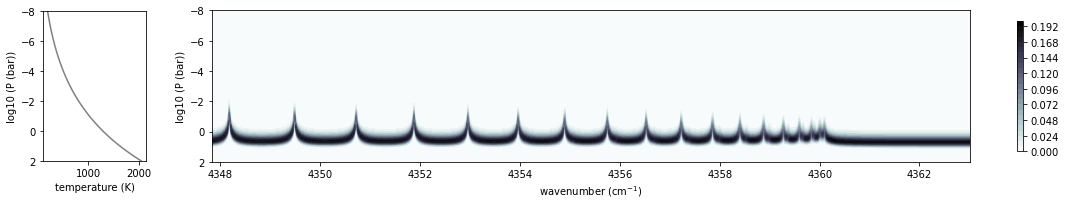

In [19]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

radiative transfering...

In [20]:
from exojax.rt import planck
from exojax.rt.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)

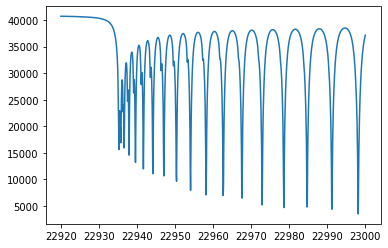

In [21]:
plt.plot(wav[::-1],F0)

applying an instrumental response and planet/stellar rotation to the raw spectrum

In [22]:
from exojax.postproc import response
from exojax.utils.constants import c
import jax.numpy as jnp

wavd=jnp.linspace(22920,23000,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R) #IP sigma need check 

Frot=response.rigidrot(nus,F0,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)

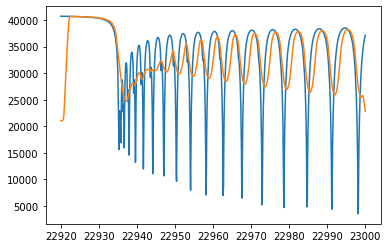

In [23]:
plt.plot(wav[::-1],F0)
plt.plot(wavd[::-1],F)

The flux decreases at the edges of the left and right sides are artificial due to the convolution. You might need to some margins of the wavenumber range to eliminate these artifacts.

In [25]:
np.savetxt("spectrum.txt",np.array([wavd,F]).T,delimiter=",")